In [52]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import os
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from tensorflow.keras.models import load_model

In [53]:
# Load your dataset
# Assume you have a CSV file with features and labels
# Replace 'your_dataset.csv' with the actual filename
data = pd.read_csv('full_df.csv')
# data.head(20)

In [54]:
# Extracting Cataract, Glaucoma, Diabetic retinopathy, Normal Fundus & Other information from the Dataset
def has_condn(term,text):
    if term in text:
        return 1
    else:
        return 0

In [55]:
def process_dataset(data):
    #create 2 more columns labelling them whether right or left cataract
    data["left_cataract"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("cataract",x))
    data["right_cataract"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("cataract",x))
  
    data["LD"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("non proliferative retinopathy",x))
    data["RD"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("non proliferative retinopathy",x))

    data["LG"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("glaucoma",x))
    data["RG"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("glaucoma",x))
    
    data["LO"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("drusen",x))
    data["RO"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("drusen",x))
    
    #store the right/left cataract images ids in a array
    left_cataract_images = data.loc[(data.C ==1) & (data.left_cataract == 1)]["Left-Fundus"].values
    right_cataract_images = data.loc[(data.C == 1) & (data.right_cataract == 1)]["Right-Fundus"].values
  
    #store the left/right normal image ids in a array
    left_normal = data.loc[(data.C == 0) & (data["Left-Diagnostic Keywords"] == "normal fundus")]['Left-Fundus'].sample(350,random_state=42).values
    right_normal = data.loc[(data.C == 0) & (data["Right-Diagnostic Keywords"] == "normal fundus")]['Right-Fundus'].sample(350,random_state=42).values
    
    #store the left/right diabetes image ids
    left_diab = data.loc[(data.C == 0) & (data.LD == 1)]["Left-Fundus"].values
    right_diab = data.loc[(data.C == 0) & (data.RD == 1)]["Right-Fundus"].values 

    #store the left/right glaucoma image ids
    left_glaucoma = data.loc[(data.C == 0) & (data.LG == 1)]["Left-Fundus"].values
    right_glaucoma = data.loc[(data.C == 0) & (data.RG == 1)]["Right-Fundus"].values 
    
    #store the left/right other image ids
    left_other = data.loc[(data.C == 0) & (data.LO == 1)]["Left-Fundus"].values
    right_other = data.loc[(data.C == 0) & (data.RO == 1)]["Right-Fundus"].values 
    
    normalones = np.concatenate((left_normal,right_normal),axis = 0);
    cataractones = np.concatenate((left_cataract_images,right_cataract_images),axis = 0);
    diabones = np.concatenate((left_diab,right_diab),axis = 0);
    glaucoma = np.concatenate((left_glaucoma,right_glaucoma),axis = 0);
    other = np.concatenate((left_other,right_other),axis = 0);
    
    return normalones,cataractones,diabones, glaucoma, other;

In [56]:
normal , cataract , diab, glaucoma , other = process_dataset(data);

print("Dataset stats::")
print("Normal ::" , len(normal))
print("Cataract ::" , len(cataract))
print("Diabetes ::" , len(diab))
print("Glaucoma ::" , len(glaucoma))
print("Other ::" , len(other))

Dataset stats::
Normal :: 700
Cataract :: 594
Diabetes :: 1818
Glaucoma :: 610
Other :: 324


In [57]:
# Creating dataset from images

dataset_dir = "D:\documents\Fiverr\diseases_project\data\preprocessed_images"
image_size=224
images = []
labels = []
dataset = []
def dataset_generator(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
            # image = images.append(image.flatten())  # Flatten the image into a 1D array
        except:
            continue
        # dataset.append(np.array(image.flatten()))
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [58]:
# Normal == 0
# Cataract == 1
# Diabetes == 2
# Glaucoma == 3
# Other == 4

dataset = dataset_generator(normal,0)
dataset = dataset_generator(cataract,1)
dataset = dataset_generator(diab,2)
dataset = dataset_generator(glaucoma,3)
dataset = dataset_generator(other,4)

len(dataset)

100%|██████████| 324/324 [00:02<00:00, 116.30it/s]


3999

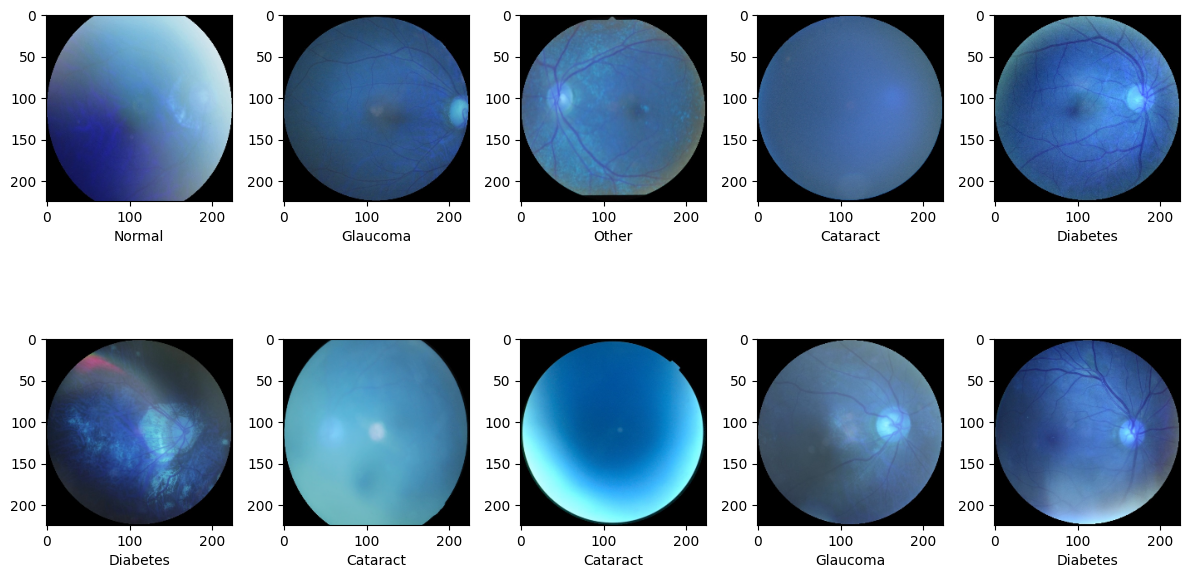

In [59]:
# Show dataset images
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    
    if category== 0:
        label = "Normal"
    elif category == 1 :
        label = "Cataract"
    elif category == 2:
        label = "Diabetes"
    elif category == 3:
        label = "Glaucoma"
    else:
        label = "Other"
           
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()   

In [60]:
# dividing dataset into x(features) & y(target)
x = np.array([i[0] for i in dataset]).reshape(-1, image_size, image_size, 3)
y = np.array([i[1] for i in dataset])

In [61]:
# Splitting dataset for testing and training
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42)

In [62]:
# print(x_train.shape)
# print(x_test.shape)
num_samples_train, height_train, width_train, channels_train = x_train.shape
num_samples_test, height_test, width_test, channels_test = x_test.shape

# Reshape images to 1D arrays
x_train_reshaped = x_train.reshape((num_samples_train, height_train * width_train * channels_train))
x_test_reshaped = x_test.reshape((num_samples_test, height_test * width_test * channels_test))


In [63]:
# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=56)

In [64]:
# Train the classifier
rf_classifier.fit(x_train_reshaped, y_train)

RandomForestClassifier(random_state=56)

In [65]:
# Make predictions on the test set

# y_pred = rf_classifier.predict(x_test)
y_pred = []
for i in rf_classifier.predict(x_test_reshaped):
    y_pred.append(np.argmax(np.array(i)).astype("int32"))

print(y_pred)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [66]:
print(accuracy_score(y_test,y_pred))

0.165


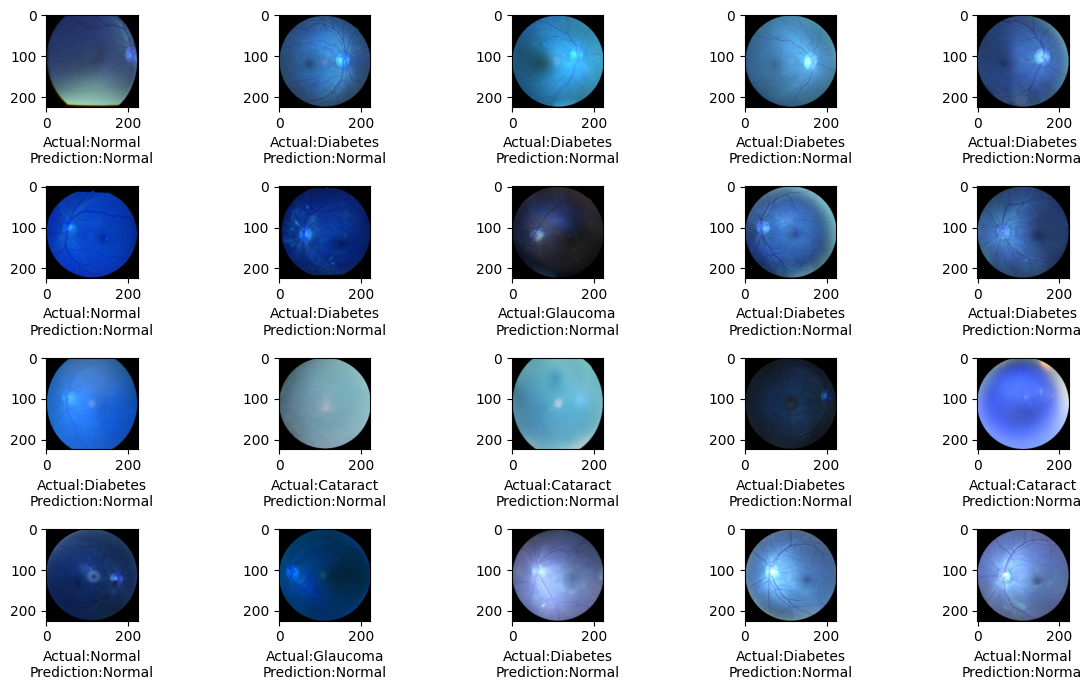

In [67]:
plt.figure(figsize=(12,7))
for i in range(20):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]
    
    if category== 0:
        label = "Normal"
    elif category == 1 :
        label = "Cataract"
    elif category == 2:
        label = "Diabetes"
    elif category == 3:
        label = "Glaucoma"
    else:
        label = "Other"

    if pred_category== 0:
        pred_label = "Normal"
    elif pred_category == 1 :
        pred_label = "Cataract"
    elif pred_category == 2:
        pred_label = "Diabetes"
    elif pred_category == 3:
        pred_label = "Glaucoma"
    else:
        pred_label = "Other"
        
    plt.subplot(4,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout() 


In [68]:
from joblib import load

# Load the saved model
loaded_rf_model = load(model_filename)

# Now, you can use loaded_rf_model for predictions


In [70]:
import cv2
import numpy as np
from joblib import load

# Load the saved model
loaded_rf_model = load('random_forest_model.joblib')

# Path to the new image
new_image_path = 'image\path'

# Read and preprocess the new image
new_image = cv2.imread(new_image_path)
new_image = cv2.resize(new_image, (224, 224))
new_image = new_image / 255.0
new_image = new_image.reshape((1, -1))  # Reshape the image to match the input shape of the RandomForestClassifier

# Perform inference
prediction = loaded_rf_model.predict(new_image)

# Now 'prediction' contains the predicted class label for the new image
print(f"Predicted class: {prediction}")


Predicted class: [3]
